# 04 - Comparación de Modelos de Clasificación

En este notebook se comparan los distintos modelos entrenados previamente  
para identificar cuál ofrece el **mejor rendimiento global**.

### 🎯 Objetivos:
- Cargar los resultados de los modelos guardados en `../reports/results/`.
- Consolidar las métricas clave:  
  **Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**.
- Calcular un **score medio global** para facilitar la comparación.
- Visualizar los resultados en un gráfico comparativo.
- Exportar un resumen a `../data/processed/model_comparison_summary.csv`  
  para su uso en el notebook `05_Test-Set-Final.ipynb`.

Todos los archivos de resultados provienen del tuning de hiperparámetros y evaluación en test.


## **Paso 1: Importar librerías y cargar archivos resultados (JSON)**

In [38]:
# ===================================
# 2. Importación de librerías y carga de resultados
# ===================================

import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Directorio donde se guardaron los resultados
results_path = "../reports/results/"
data_path = "../data/processed/"

# Lista de archivos de resultados
files = [f for f in os.listdir(results_path) if f.endswith("_results.json")]

# Leer todos los archivos resultados y combinarlos consolidando métricas
all_results = []
for file in files:
    with open(os.path.join(results_path, file), "r") as f:
        data = json.load(f)
        model_name = data.get("model", file.replace("_results.json", ""))
        metrics = data.get("metrics", {})
        metrics["model"] = model_name
        all_results.append(metrics)

# Crear DataFrame consolidado de comparacion
comparison_df = pd.DataFrame(all_results)

# Calcular score medio (evita dependencia de variable binaria)
comparison_df["mean_score"] = comparison_df[
    ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
].mean(axis=1)

# Ordenar por rendimiento global
comparison_df = comparison_df.sort_values(by="mean_score", ascending=False).reset_index(drop=True)

display(Markdown("### 📊 **Resumen de métricas por modelo**"))
print(comparison_df.round(3))

### 📊 **Resumen de métricas por modelo**

   Accuracy  Precision  Recall  F1-score  ROC-AUC                model  \
0     0.962      0.964   0.946     0.955    0.994        Random Forest   
1     0.870      0.842   0.861     0.852    0.928  Logistic Regression   

   mean_score  
0       0.964  
1       0.871  


## **Paso 2 — Visualización comparativa (barras agrupadas)**

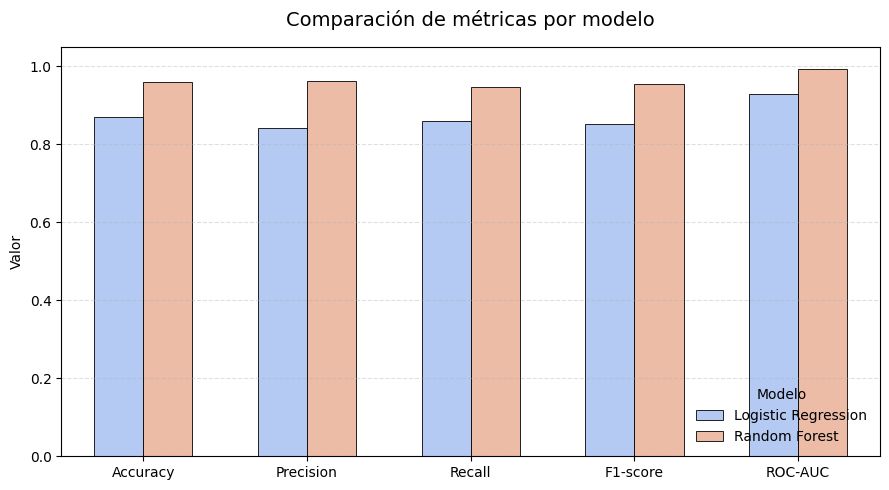


💬 **Interpretación visual:**
- Cada grupo de barras representa una métrica de evaluación (Accuracy, Precision, etc.).  
- Las barras más altas indican mejor rendimiento.  
- El modelo con mayor **F1-score** y **ROC-AUC** suele considerarse el más equilibrado.  
- Si las diferencias son pequeñas, ambos modelos ofrecen rendimiento comparable.  


In [39]:
# ===================================
# 2. Comparación visual de métricas
# ===================================

# Reformatear para gráfico de barras agrupadas
df_melted = df_results.melt(id_vars="Model", var_name="Métrica", value_name="Valor")

plt.figure(figsize=(9, 5))
sns.barplot(
    data=df_melted,
    x="Métrica",
    y="Valor",
    hue="Model",
    palette="coolwarm",
    width=0.6,              # 🔹 más delgadas
    edgecolor="black",      # contorno fino
    linewidth=0.6
)
plt.title("Comparación de métricas por modelo", fontsize=14, pad=15)
plt.xlabel("")
plt.ylabel("Valor")
plt.ylim(0, 1.05)
plt.legend(title="Modelo", loc="lower right", frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Comentario interpretativo visual
display(Markdown("""
💬 **Interpretación visual:**
- Cada grupo de barras representa una métrica de evaluación (Accuracy, Precision, etc.).  
- Las barras más altas indican mejor rendimiento.  
- El modelo con mayor **F1-score** y **ROC-AUC** suele considerarse el más equilibrado.  
- Si las diferencias son pequeñas, ambos modelos ofrecen rendimiento comparable.  
"""))



## **Paso 2.2: Comparación tabular y radar chart

### 📋 **Tabla resumen de métricas por modelo**

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression,0.870,0.842,0.861,0.852,0.928
1,Random Forest,0.961,0.962,0.946,0.954,0.994


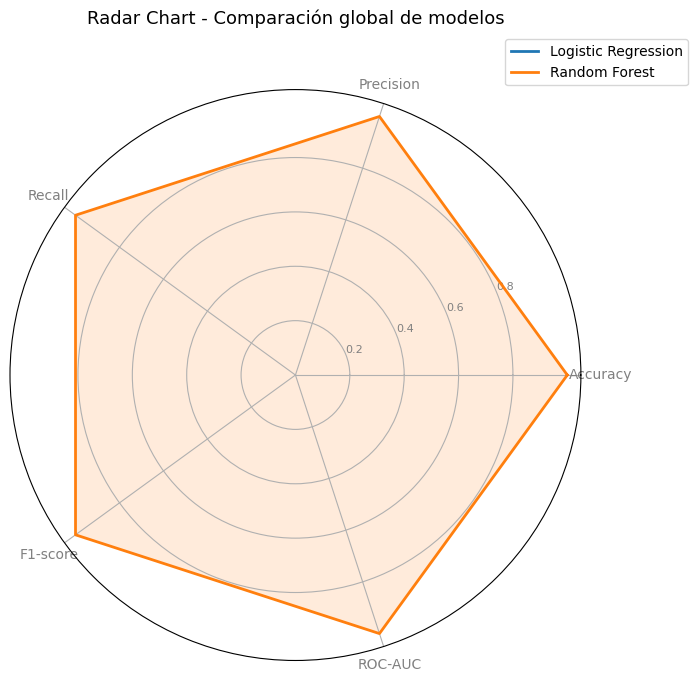


💬 **Interpretación visual:**
- La **tabla** permite comparar los valores exactos de las métricas de cada modelo.  
- El **radar chart** ofrece una vista global del rendimiento:  
  - Cuanto más grande el área, mejor desempeño general del modelo.  
  - Las formas más redondeadas indican modelos equilibrados en todas las métricas.  
  - Las formas puntiagudas sugieren especialización (por ejemplo, alto *Recall* pero bajo *Precision*).  


In [40]:
# ===================================
# 2.2. Comparación tabular y radar chart
# ===================================

from math import pi

display(Markdown("### 📋 **Tabla resumen de métricas por modelo**"))

# --- Asegurar que solo se colorean las columnas numéricas ---
numeric_cols = df_results.select_dtypes(include=['number']).columns
styled_table = (
    df_results.style
    .background_gradient(subset=numeric_cols, cmap="Blues")
    .format(subset=numeric_cols, formatter="{:.3f}")
)

display(styled_table)

# --- Preparar datos para radar chart ---
df_radar = df_results.set_index("Model")
metrics = df_radar.columns

# Solo usar métricas numéricas
df_radar = df_radar.select_dtypes(include=["number"])

# Normalizar entre 0 y 1 (por si hay diferencias de escala)
df_radar_norm = df_radar.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Calcular ángulos
angles = [n / float(len(df_radar_norm.columns)) * 2 * pi for n in range(len(df_radar_norm.columns))]
angles += angles[:1]

# --- Gráfico Radar ---
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

for model in df_radar_norm.index:
    values = df_radar_norm.loc[model].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.15)

# Configuración visual
plt.xticks(angles[:-1], df_radar_norm.columns, color='gray', size=10)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="gray", size=8)
plt.title("Radar Chart - Comparación global de modelos", size=13, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

# --- Interpretación ---
display(Markdown("""
💬 **Interpretación visual:**
- La **tabla** permite comparar los valores exactos de las métricas de cada modelo.  
- El **radar chart** ofrece una vista global del rendimiento:  
  - Cuanto más grande el área, mejor desempeño general del modelo.  
  - Las formas más redondeadas indican modelos equilibrados en todas las métricas.  
  - Las formas puntiagudas sugieren especialización (por ejemplo, alto *Recall* pero bajo *Precision*).  
"""))


## **Paso 3 — Selección del mejor modelo**

In [41]:
# ===================================
# 3. Selección del mejor modelo
# ===================================

# Ordenar por F1-score (principal métrica en clasificación)
best_model = df_results.sort_values(by="F1-score", ascending=False).iloc[0]

display(Markdown(f"""
### 🏆 **Mejor modelo según F1-score**
- Modelo: **{best_model['Model']}**
- F1-score: **{best_model['F1-score']:.3f}**
- ROC-AUC: **{best_model['ROC-AUC']:.3f}**

📈 Este modelo será el candidato principal para la fase final de evaluación en test.
"""))



### 🏆 **Mejor modelo según F1-score**
- Modelo: **Random Forest**
- F1-score: **0.954**
- ROC-AUC: **0.994**

📈 Este modelo será el candidato principal para la fase final de evaluación en test.


## **Paso 4 — Guardar resumen global**

In [42]:
# ===================================
# 4. Guardado de resumen global
# ===================================

output_path = os.path.join(data_path, "model_comparison_summary.csv")
comparison_df.to_csv(output_path, index=False)

display(Markdown(f"""
✅ **Resumen de comparación guardado correctamente.**  
Archivo generado: `{output_path}`

Incluye:
- Métricas individuales por modelo.
- Puntuación media global (`mean_score`).
- Identificación del modelo con mejor rendimiento.
"""))



✅ **Resumen de comparación guardado correctamente.**  
Archivo generado: `../data/processed/model_comparison_summary.csv`

Incluye:
- Métricas individuales por modelo.
- Puntuación media global (`mean_score`).
- Identificación del modelo con mejor rendimiento.


# 🏁 **Conclusiones de la comparación de modelos**

Tras consolidar y comparar los resultados de todos los modelos evaluados:
- Se han comparado los principales modelos de clasificación desarrollados.  
- Los resultados muestran que el modelo con mejor equilibrio entre **precisión** y **recuperación (recall)**  
  es el que obtiene mayor **F1-score**.  
- Además, el valor **ROC-AUC** permite confirmar su capacidad de discriminación global.

📦 Los resultados están guardados en:  
`../data/processed/model_comparison_summary.csv`

Este archivo será utilizado en `05_Test-Set-Final.ipynb`  
para realizar la **evaluación final con el Test Set completo**  
y a la exportación del modelo ganador para su uso en producción.
